In [11]:
from collections import Counter

import numpy as np
import matplotlib
# matplotlib.use("agg")    # must select backend before importing pyplot
import matplotlib.pyplot as plt
from dimod import BinaryQuadraticModel

from neal import SimulatedAnnealingSampler
from dwave.system import LeapHybridSampler
from dwave.system import DWaveSampler, EmbeddingComposite

In [12]:
sampler_simu = SimulatedAnnealingSampler()
sampler_real = EmbeddingComposite(DWaveSampler())
sampler_leap = LeapHybridSampler()

In [13]:
def exact_cover_bqm(problem_set, subsets):  
    """Returns a BQM for an exact cover.
 
    An exact cover is a collection of subsets of `problem_set` that contains every 
    element in `problem_set` exactly once.
    
    Args:
        problem_set : iterable
            An iterable of unique numbers.

        subsets : list(iterable(numeric))
            A list of subsets of `problem_set` used to find an exact cover.
    """
    bqm = BinaryQuadraticModel({}, {}, 0, 'BINARY')

    for element in problem_set:
        bqm.offset += 1

        for i in range(len(subsets)):    
            if element in subsets[i]:
                bqm.add_variable(i, -1)

                for j in range(i):         
                    if element in subsets[j]:
                        bqm.add_interaction(i, j, 2)

    return bqm

In [14]:
def build_subsets(n):
    """Returns a list of subsets of constraints corresponding to every
    position on the chessboard.

    Each constraint is represented by a unique number (ID). Each subset
    should contain:
    1) Exactly one column constraint ID (0 to n-1).
    2) Exactly one row constraint ID (n to 2*n-1).
    3) At most one diagonal (top-left to bottom-right) constraint ID (2*n to
       4*n-4).
    4) At most one anti-diagonal (bottom-left to top-right) constraint ID (4*n-3
       to 6*n-7).
    """
    subsets = []
    for x in range(n):
        for y in range(n):
            col = x
            row = y + n

            subset = {col, row}

            diag = x + y + (2*n - 1)
            min_diag = 2*n
            max_diag = 4*n - 4

            if diag >= min_diag and diag <= max_diag:
                subset.add(diag)

            anti_diag = (n - 1 - x + y) + (4*n - 4)
            min_anti_diag = 4*n - 3
            max_anti_diag = 6*n - 7

            if anti_diag >= min_anti_diag and anti_diag <= max_anti_diag:
                subset.add(anti_diag)

            subsets.append(subset)

    return subsets

def handle_diag_constraints(bqm, subsets, diag_constraints):
    """Update bqm with diagonal (and anti-diagonal) constraints.
    Duplicates are penalized.
    """
    for constraint in diag_constraints:
        for i in range(len(subsets)):
            if constraint in subsets[i]:
                for j in range(i):
                    if constraint in subsets[j]:
                        bqm.add_interaction(i, j, 2)
    return bqm

In [15]:
def show_problem(qm):
    q = qm.copy()
    q.relabel_variables_as_integers(inplace=True)
    m = q.to_numpy_matrix()
    plt.imshow(m, cmap="RdBu")
    plt.colorbar()
    plt.show()
    return m

In [16]:
def n_queens(n):
    """Returns a potential solution to the n-queens problem in a list of sets,
    each containing constraint IDs representing a queen's location.

    Args:
        n: Number of queens to place.

        sampler: A binary quadratic model sampler. Defaults to dwave-system's LeapHybridSampler.
    """
    num_row_col_constraints = 2 * n
    row_col_constraint_ids = set(range(num_row_col_constraints))

    num_diag_constraints = 4 * n - 6   # includes anti-diag constraints
    diag_constraint_ids = set(range(num_row_col_constraints, num_row_col_constraints + num_diag_constraints))

    # Build subsets of constraint IDs. Each subset will become a variable in our BQM.
    subsets = build_subsets(n)

    # Build BQM with only row/col constraints
    bqm = exact_cover_bqm(row_col_constraint_ids, subsets)

    # Add diag/anti-diag constraints - duplicates are penalized.
    bqm = handle_diag_constraints(bqm, subsets, diag_constraint_ids)

    return bqm, subsets

def solve_n_queens(bqm, sampler, num_reads=None):
    if num_reads is None:
        sampleset = sampler.sample(bqm, label='Example - N Queens')
    else:
        sampleset = sampler.sample(bqm, label='Example - N Queens', num_reads=num_reads)
    # sample = sampleset.first.sample
    return sampleset

def get_solution_n_queens(sample, subsets):
    return [subsets[i] for i in sample if sample[i]]

In [17]:
def is_a_valid_solution(solution, size):
    msg = ""
    s = np.array(list(solution.values())).reshape((size,-1))

    if not msg:
        failed_tot_rows = np.sum(s, axis=1) > 1
        if np.count_nonzero(failed_tot_rows):
            msg = f"More than 1 queen per row: {np.nonzero(failed_tot_rows)[0]}."

    if not msg:
        failed_tot_cols = np.sum(s, axis=0) > 1
        if np.count_nonzero(failed_tot_cols):
            msg = f"More than 1 queen per column: {np.nonzero(failed_tot_cols)[0]}."

    if not msg:
        failed_tot_diags = [np.trace(s, k) > 1 for k in range(-size+1, size)]
        if np.count_nonzero(failed_tot_diags):
            msg = f"More than 1 queen per diagonal: {np.nonzero(failed_tot_diags)[0]-size+1}."

    if not msg:
        fs = np.fliplr(s)
        failed_tot_antidiags = [np.trace(fs, k) > 1 for k in range(-size+1, size)]
        if np.count_nonzero(failed_tot_antidiags):
            msg = f"More than 1 queen per anti-diagonal: {-(np.nonzero(failed_tot_antidiags)[0]-size+1)}."

    if not msg:
        tot = np.sum(s)
        if tot != size:
            msg = f"Not exactly {size} queens placed, but {tot}."

    if msg:
        ret = False
    else:
        msg = "Solution is valid."
        ret = True
    return (ret, msg)
    
def show_solutions(solutions, size):
    n = len(solutions)
    fig, ax = plt.subplots(1, n, figsize=(5*n, 3))
    if n ==1:
        ax = (ax,)
    for solution, iax in zip(solutions, ax):
        valid, msg = is_a_valid_solution(solution, size)
        s = np.array(list(solution.values())).reshape((size,-1))
        iax.imshow(s)
        iax.set_xticks(np.arange(-.5, size, 1))
        iax.set_yticks(np.arange(-.5, size, 1))
        iax.set_xticklabels(np.arange(0, size+1, 1))
        iax.set_yticklabels(np.arange(0, size+1, 1))
        iax.grid()
        iax.set_title(f"Num. Queens: {np.sum(s)} / {size}.\nValid: {valid}\n{msg}")

ipykernel_launcher:4: DeprecationWarning: bqm.to_numpy_matrix() is deprecated since dimod 0.10.0


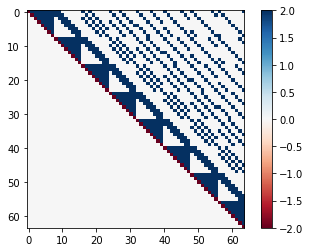

In [18]:
n = 8
num_reads_simu = 100
num_reads_real = 1000
num_reads_leap = 10

bqm, subsets = n_queens(n)
m = show_problem(bqm)

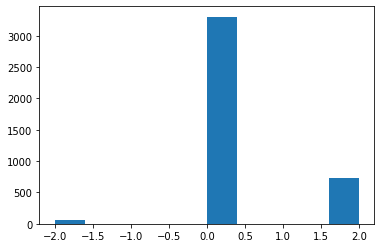

In [19]:
plt.hist(m.reshape((-1,1)))
plt.show()

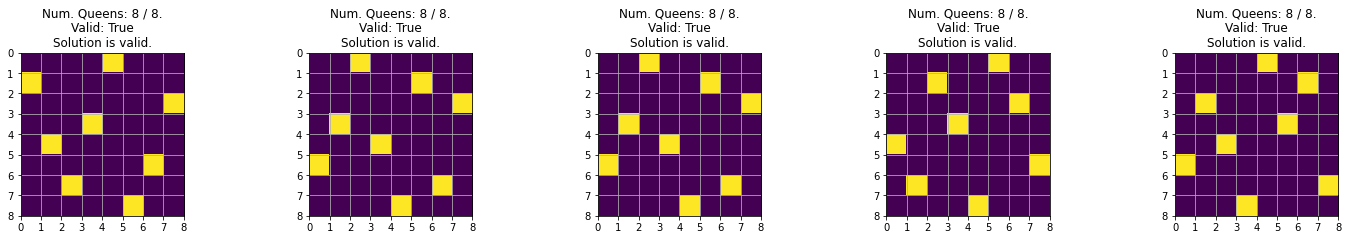

In [20]:
sampleset_simu = solve_n_queens(bqm, sampler_simu, num_reads_simu)
show_solutions(sampleset_simu.samples(5), n)

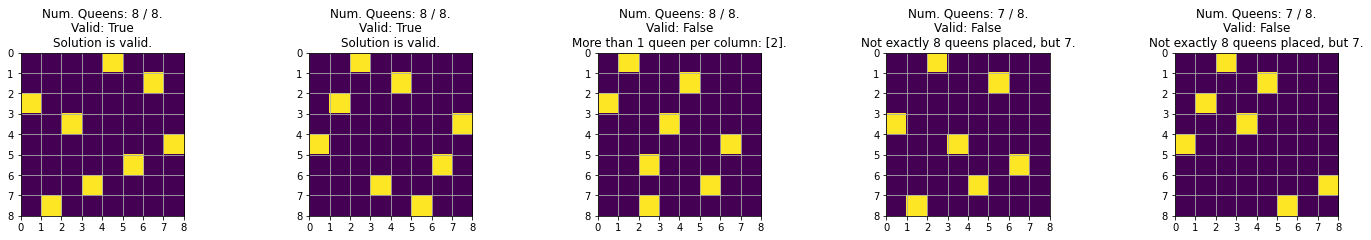

In [21]:
sampleset_real = solve_n_queens(bqm, sampler_real, num_reads_real)
show_solutions(sampleset_real.samples(5), n)

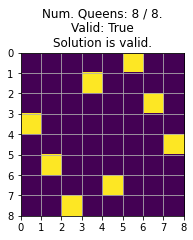

In [22]:
sampleset_leap = solve_n_queens(bqm, sampler_leap)
show_solutions(sampleset_leap.samples(5), n)